# Social Media usage and emotional impact

In [1]:
import pandas as pd  
import numpy as np  
import seaborn as sns  
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, mean_squared_error
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, OneHotEncoder

sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 6) 

df = pd.read_csv('train.csv')

#copy of the original data to work on
data_df = df.copy()

print("First 5 rows of the training data:")
print(data_df.info())
print(data_df.describe())
print(data_df.head())

First 5 rows of the training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     1001 non-null   object 
 1   Age                         1001 non-null   object 
 2   Gender                      1000 non-null   object 
 3   Platform                    1000 non-null   object 
 4   Daily_Usage_Time (minutes)  1000 non-null   float64
 5   Posts_Per_Day               1000 non-null   float64
 6   Likes_Received_Per_Day      1000 non-null   float64
 7   Comments_Received_Per_Day   1000 non-null   float64
 8   Messages_Sent_Per_Day       1000 non-null   float64
 9   Dominant_Emotion            1000 non-null   object 
dtypes: float64(5), object(5)
memory usage: 78.3+ KB
None
       Daily_Usage_Time (minutes)  Posts_Per_Day  Likes_Received_Per_Day  \
count                 1000.000000    100

# Analytical Questions
1. How does daily usage time across different social media platforms relate to dominant emotions?
Motivation: This will show if certain platforms trigger particular emotional outcomes.
2. Is there a correlation between user engagement metrics (likes, comments, messages) and Happiness_Index or Anxiety_Index?
Motivation: Understand whether high engagement leads to emotional well-being or stress.
3. How does age and/or gender affect emotional responses to social media usage?
Motivation: Identifying demographic differences can help tailor interventions to reduce anxiety or promote happiness.

In [2]:
missing_values = data_df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

for col in data_df.columns:
    if data_df[col].dtype == 'object': 
        data_df[col] = data_df[col].fillna(data_df[col].mode()[0])
    else:  
        data_df[col] = data_df[col].fillna(data_df[col].median())

print("\nMissing Values After Imputation:")
print(data_df.isnull().sum())

anomalies = data_df[data_df['Daily_Usage_Time (minutes)'] < 0]
print("Anomalies in Daily Usage Time:")
print(anomalies)

Missing values in each column:
User_ID                       0
Age                           0
Gender                        1
Platform                      1
Daily_Usage_Time (minutes)    1
Posts_Per_Day                 1
Likes_Received_Per_Day        1
Comments_Received_Per_Day     1
Messages_Sent_Per_Day         1
Dominant_Emotion              1
dtype: int64

Missing Values After Imputation:
User_ID                       0
Age                           0
Gender                        0
Platform                      0
Daily_Usage_Time (minutes)    0
Posts_Per_Day                 0
Likes_Received_Per_Day        0
Comments_Received_Per_Day     0
Messages_Sent_Per_Day         0
Dominant_Emotion              0
dtype: int64
Anomalies in Daily Usage Time:
Empty DataFrame
Columns: [User_ID, Age, Gender, Platform, Daily_Usage_Time (minutes), Posts_Per_Day, Likes_Received_Per_Day, Comments_Received_Per_Day, Messages_Sent_Per_Day, Dominant_Emotion]
Index: []


In [3]:
duplicates = data_df.duplicated().sum()
data_df = data_df.drop_duplicates()

In [4]:
data_df.dtypes
print(df['Age'].unique())
print(df['Gender'].unique())
print(df['User_ID'].unique())
print(df['Platform'].unique())
print(df['Daily_Usage_Time (minutes)'].unique())
print(df['Posts_Per_Day'].unique())
print(df['Likes_Received_Per_Day'].unique())
print(df['Comments_Received_Per_Day'].unique())
print(df['Messages_Sent_Per_Day'].unique())
print(df['Dominant_Emotion'].unique())

['25' '30' '22' '28' '33' '21' '27' '24' '29' '31' '23' '26' '34' '35'
 '32' 'Male' 'Female' 'Non-binary'
 ' işte mevcut veri kümesini 1000 satıra tamamlıyorum:']
['Female' 'Male' 'Non-binary' '27' '24' '29' '33' '31' '22' '25' '28' '30'
 '23' '34' '26' '35' '21' '32' nan]
['1' '2' '3' ... '998' '999' '1000']
['Instagram' 'Twitter' 'Facebook' 'LinkedIn' 'Whatsapp' 'Telegram'
 'Snapchat' nan]
[120.  90.  60. 200.  45. 150.  85. 110.  55. 170.  75.  95.  65. 180.
 100.  40. 125.  50. 140. 105. 190.  70.  80. 160. 145. 130. 115. 175.
 165. 155.  nan]
[ 3.  5.  2.  8.  1.  4.  6.  7. nan]
[ 45.  20.  15. 100.   5.  60.  30.  25.  10.  80.  35.  12.  90.  40.
  55.  33.   8.  70.  28.  11.  95.  18.   9.  85.  38.   6.  13.  75.
  27.  88.  22.  78.  29.  50.  36.  72.  65. 110.  14.  17. 105.  43.
  37.  42.  48.  21.  24.  23.  83.  nan]
[10. 25.  5. 30.  2. 15. 12.  3. 20.  7.  4. 23. 18. 22. 14. 26.  8. 19.
 17. 11.  6.  9. 13. 40. 16. 35. 38. 28. 36. 33. nan]
[12. 30. 20. 50. 10. 25. 1

In [5]:
invalid_age_mask = ~data_df['Age'].str.isnumeric()  # Age contains non-numeric
numeric_gender_mask = data_df['Gender'].str.isnumeric()  # Gender contains numbers
swapped_rows_mask = invalid_age_mask & numeric_gender_mask
data_df.loc[swapped_rows_mask, ['Age', 'Gender']] = data_df.loc[swapped_rows_mask, ['Gender', 'Age']].values
data_df['Age'] = pd.to_numeric(data_df['Age'], errors='coerce')
data_df['Age'] = data_df['Age'].fillna(data_df['Age'].median())
data_df['Gender'] = data_df['Gender'].astype('category')
print("Cleaned DataFrame:")
print(data_df)

data_df['Age'] = data_df['Age'].round().astype(int)

print("\nUnique values in 'Age' column:")
print(data_df['Age'].unique())

print("\nUnique values in 'Gender' column:")
print(data_df['Gender'].unique())



Cleaned DataFrame:
     User_ID   Age      Gender   Platform  Daily_Usage_Time (minutes)  \
0          1  25.0      Female  Instagram                       120.0   
1          2  30.0        Male    Twitter                        90.0   
2          3  22.0  Non-binary   Facebook                        60.0   
3          4  28.0      Female  Instagram                       200.0   
4          5  33.0        Male   LinkedIn                        45.0   
...      ...   ...         ...        ...                         ...   
996      996  33.0  Non-binary    Twitter                        85.0   
997      997  22.0      Female   Facebook                        70.0   
998      998  35.0        Male   Whatsapp                       110.0   
999      999  28.0  Non-binary   Telegram                        60.0   
1000    1000  27.0      Female   Snapchat                       120.0   

      Posts_Per_Day  Likes_Received_Per_Day  Comments_Received_Per_Day  \
0               3.0           

One-Hot Encoding 

In [6]:
data_df = pd.get_dummies(data_df, columns=['Gender', 'Platform', 'Dominant_Emotion'], drop_first=True)
print(data_df.head())

  User_ID  Age  Daily_Usage_Time (minutes)  Posts_Per_Day  \
0       1   25                       120.0            3.0   
1       2   30                        90.0            5.0   
2       3   22                        60.0            2.0   
3       4   28                       200.0            8.0   
4       5   33                        45.0            1.0   

   Likes_Received_Per_Day  Comments_Received_Per_Day  Messages_Sent_Per_Day  \
0                    45.0                       10.0                   12.0   
1                    20.0                       25.0                   30.0   
2                    15.0                        5.0                   20.0   
3                   100.0                       30.0                   50.0   
4                     5.0                        2.0                   10.0   

   Gender_Male  Gender_Non-binary  Platform_Instagram  Platform_LinkedIn  \
0        False              False                True              False   
1     

In [7]:
numerical_features = ['Daily_Usage_Time (minutes)', 'Likes_Received_Per_Day', 
                      'Comments_Received_Per_Day', 'Messages_Sent_Per_Day', 'Posts_Per_Day']

scaler = StandardScaler()
data_df[numerical_features] = scaler.fit_transform(data_df[numerical_features])

print("Standardized Numerical Features:")
print(data_df[numerical_features].head())

Standardized Numerical Features:
   Daily_Usage_Time (minutes)  Likes_Received_Per_Day  \
0                    0.619917                0.193751   
1                   -0.153017               -0.754354   
2                   -0.925951               -0.943975   
3                    2.681074                2.279582   
4                   -1.312418               -1.323217   

   Comments_Received_Per_Day  Messages_Sent_Per_Day  Posts_Per_Day  
0                  -0.636648              -1.241151      -0.167658  
1                   1.065804               0.874559       0.877986  
2                  -1.204131              -0.300835      -0.690481  
3                   1.633287               3.225349       2.446454  
4                  -1.544622              -1.476230      -1.213303  


# EDA

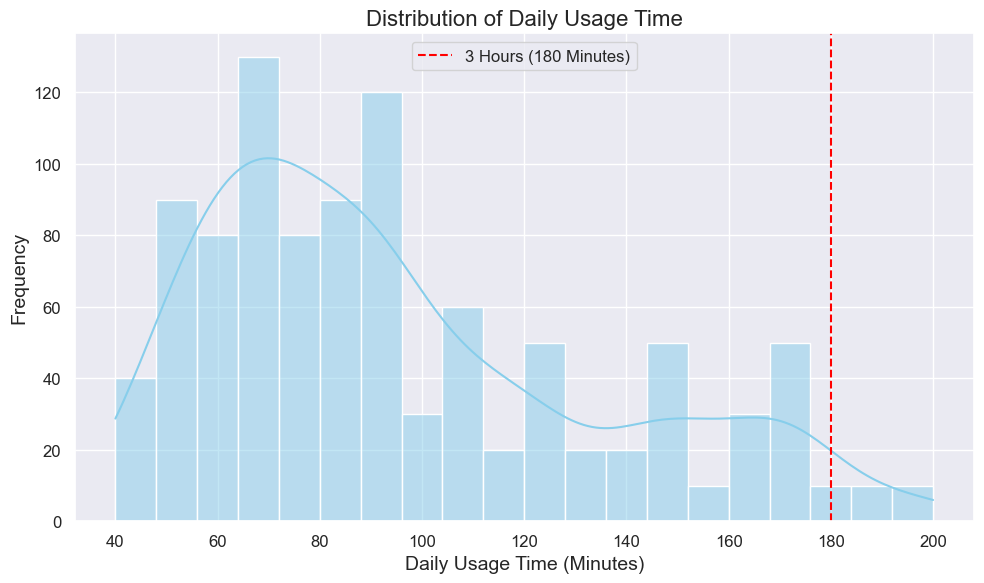

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Daily_Usage_Time (minutes)'], bins=20, kde=True, color='skyblue')

plt.title('Distribution of Daily Usage Time', fontsize=16)
plt.xlabel('Daily Usage Time (Minutes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axvline(x=180, color='red', linestyle='--', label='3 Hours (180 Minutes)')
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

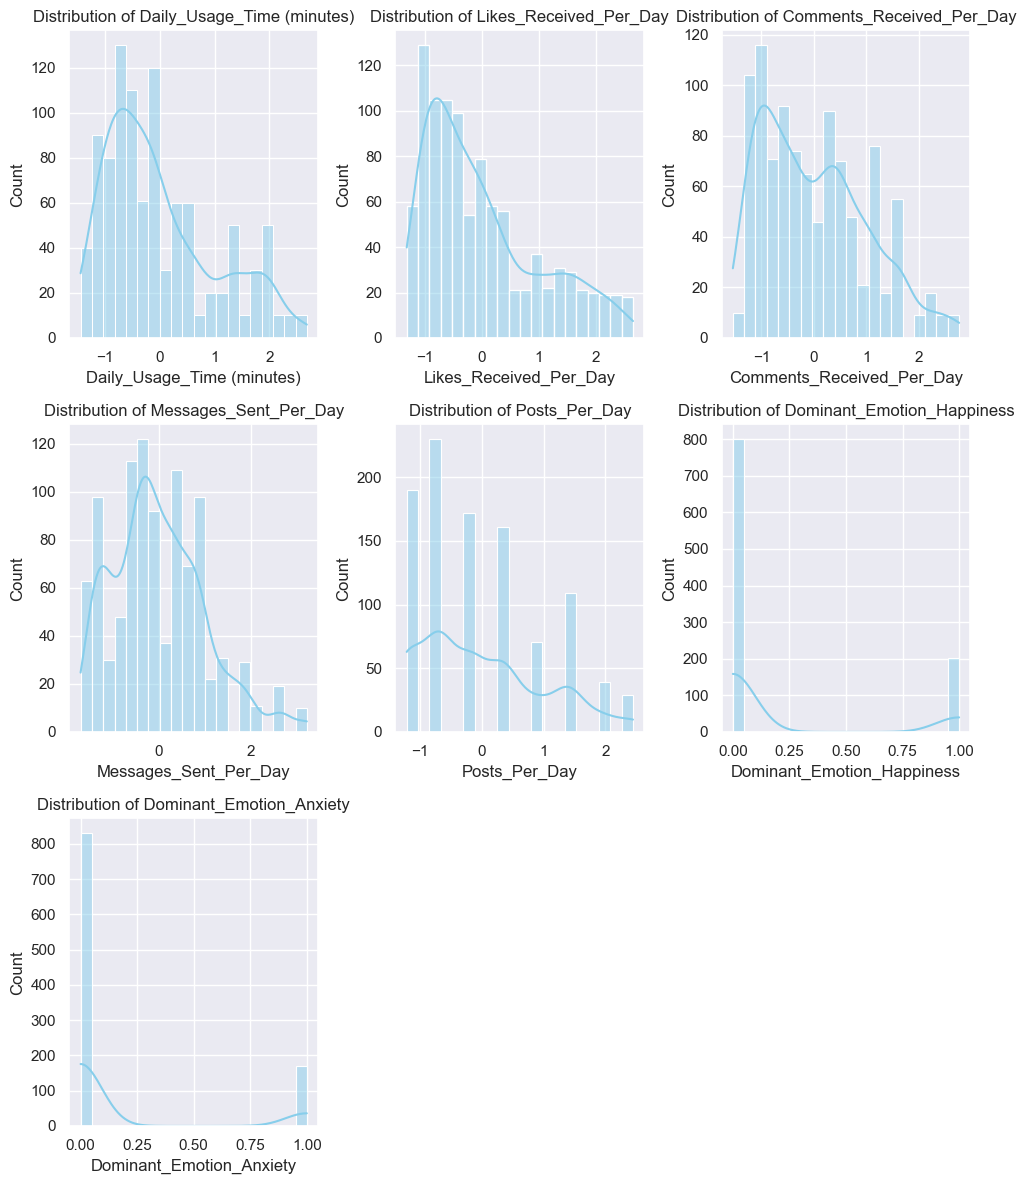

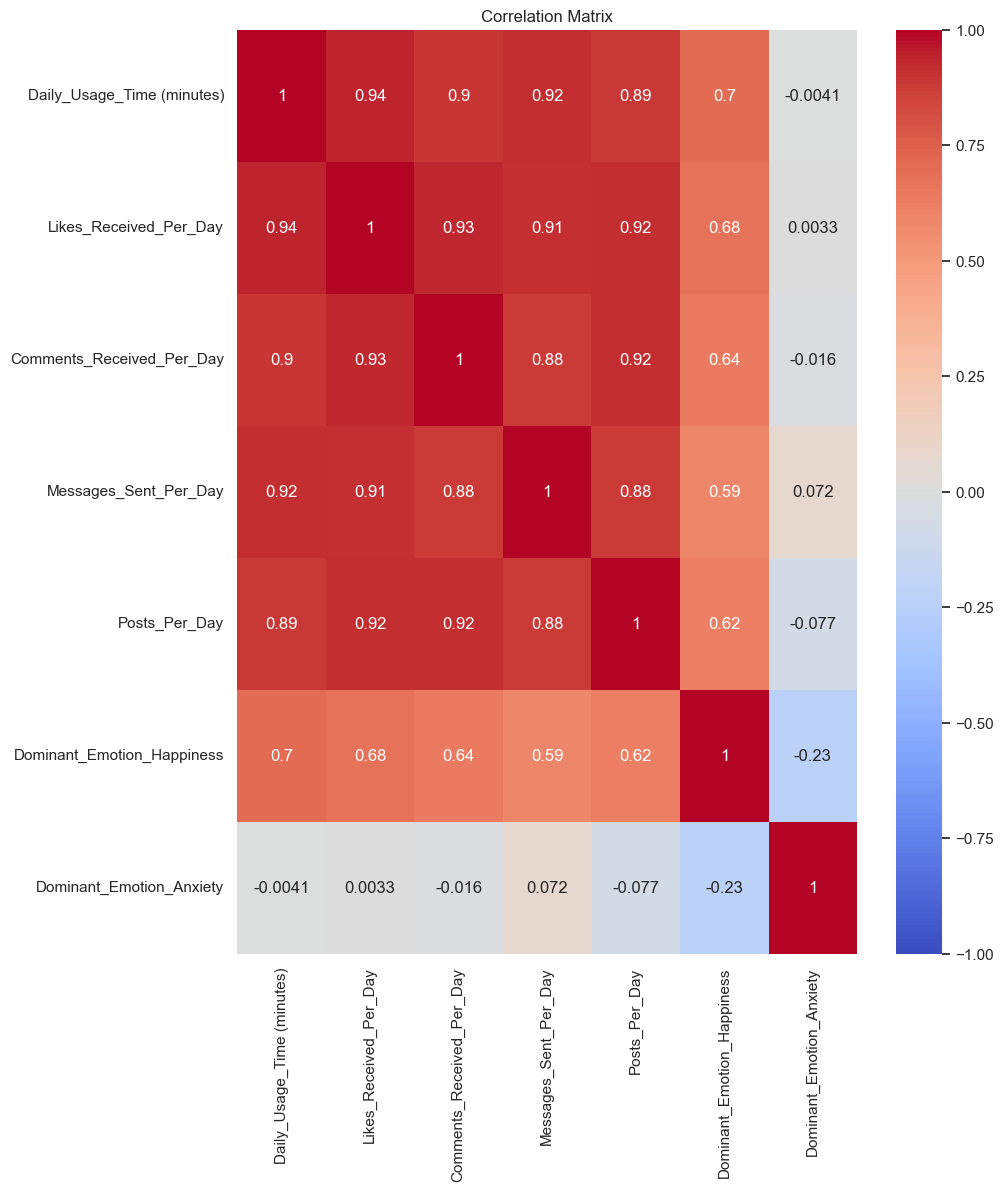

<Figure size 1000x1000 with 0 Axes>

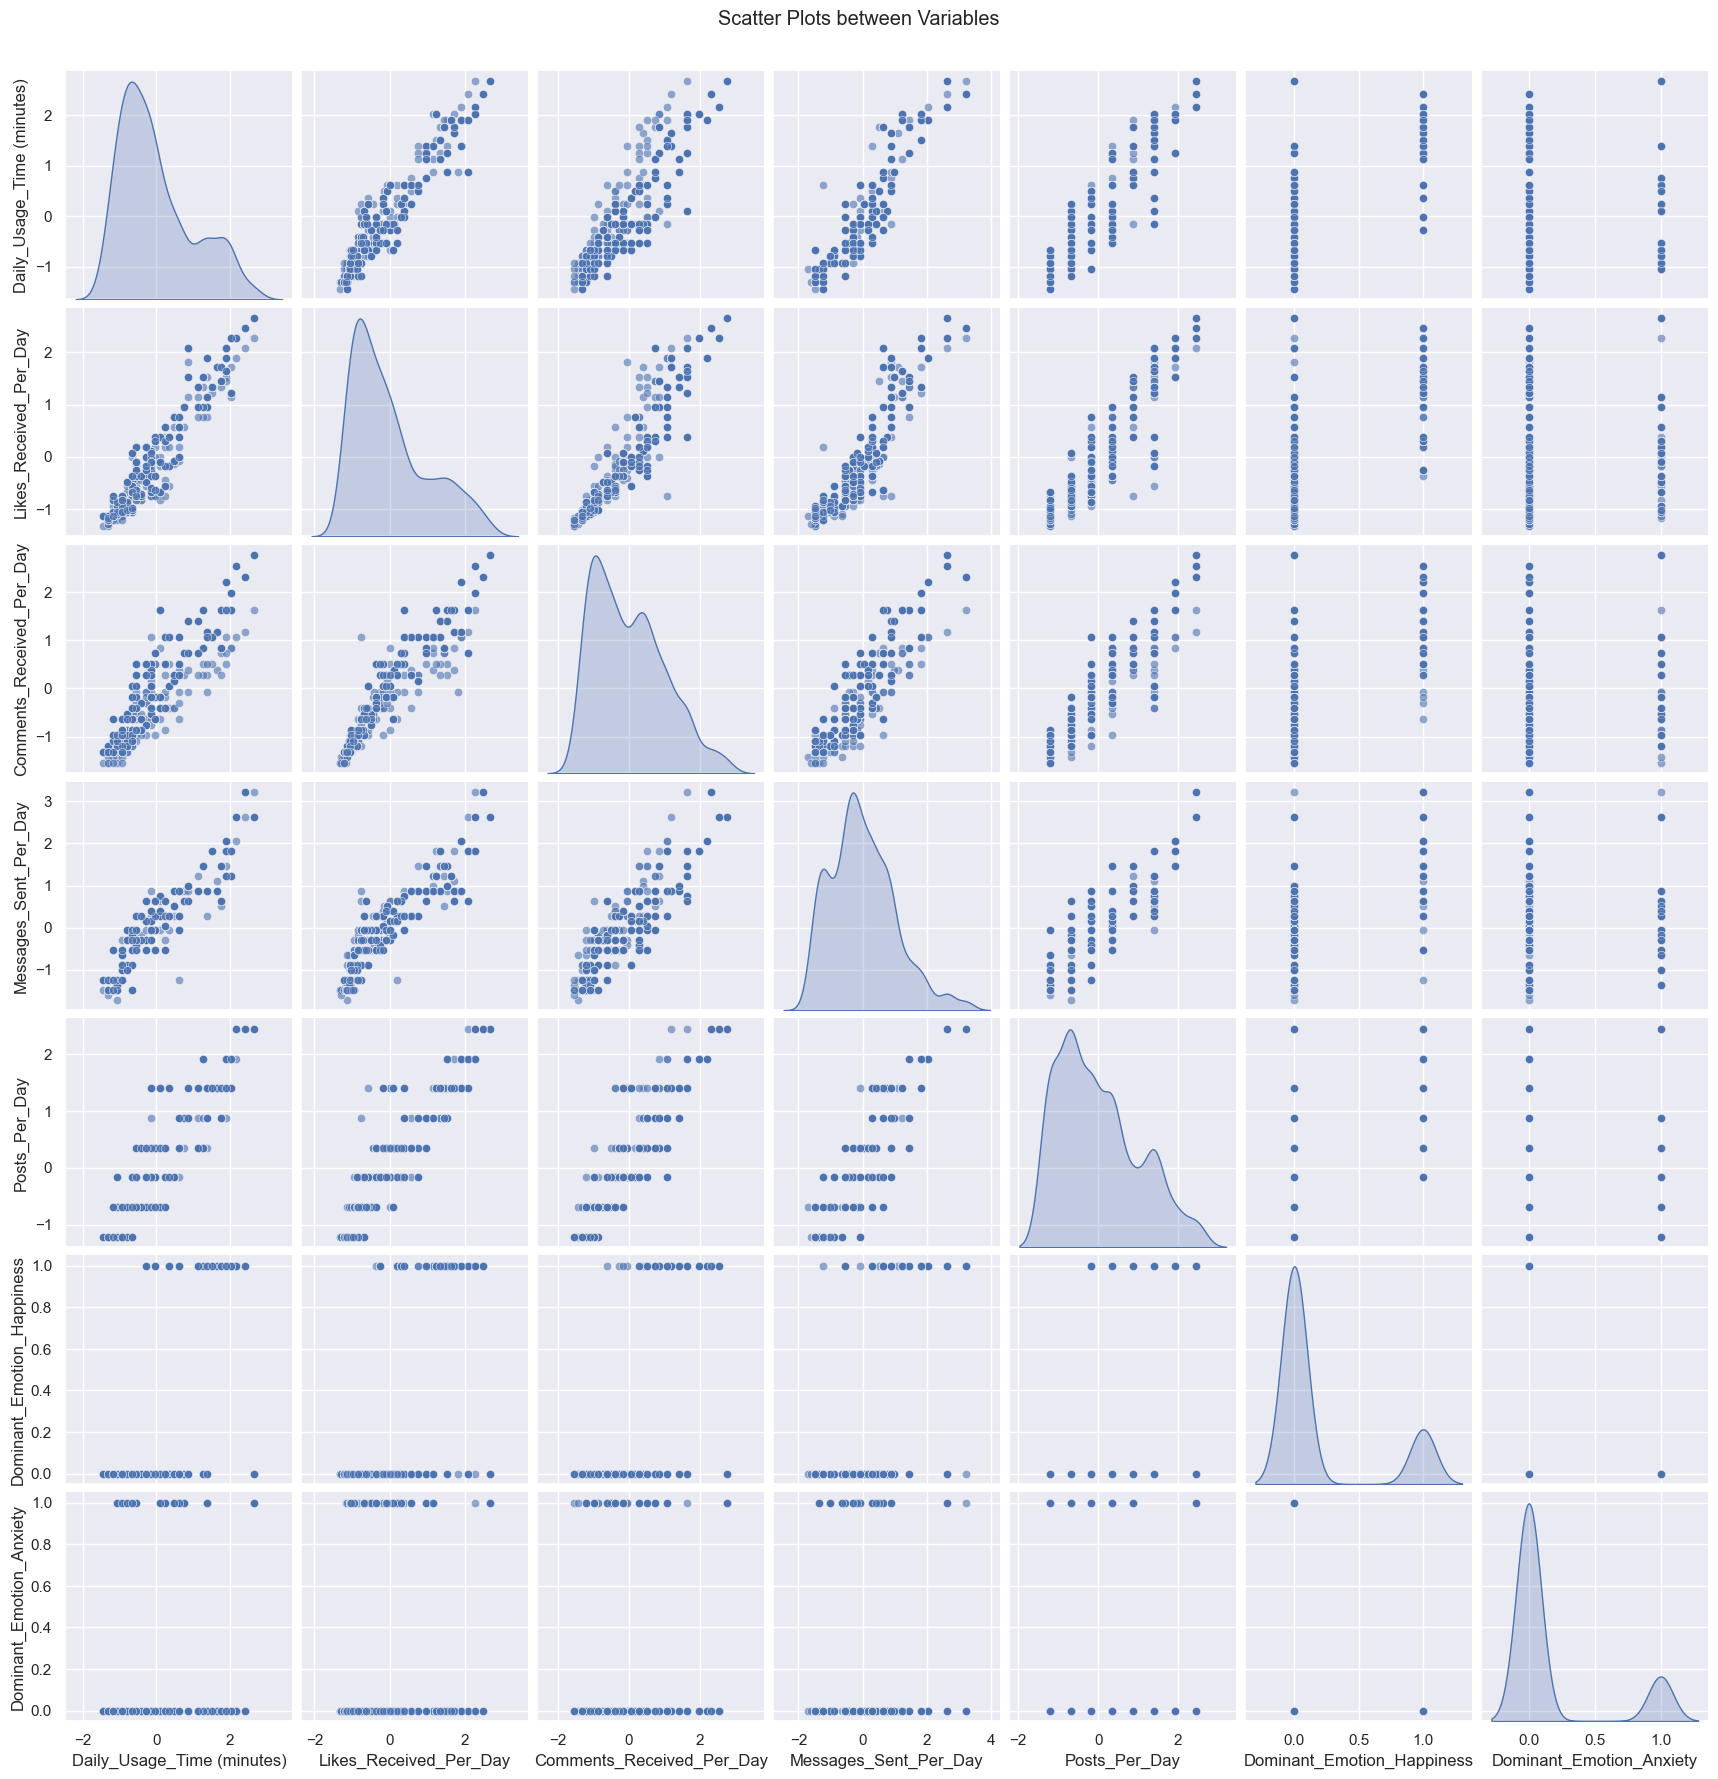

In [9]:

columns_to_visualize = ['Daily_Usage_Time (minutes)', 'Likes_Received_Per_Day', 'Comments_Received_Per_Day', 'Messages_Sent_Per_Day', 'Posts_Per_Day',  'Dominant_Emotion_Happiness', 'Dominant_Emotion_Anxiety']

plt.figure(figsize=(10, 12))
for i, column in enumerate(columns_to_visualize, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data_df[column], kde=True, bins=20, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
plt.show()

correlation_matrix = data_df[columns_to_visualize].corr()

plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

plt.figure(figsize=(10, 10))
sns.pairplot(data_df[columns_to_visualize], kind='scatter', diag_kind='kde', plot_kws={'alpha':0.6})
plt.suptitle("Scatter Plots between Variables", y=1.02)
plt.show()

create Age Groups

In [10]:
data_df['Total_Interactions'] = (
    data_df['Likes_Received_Per_Day'] + 
    data_df['Comments_Received_Per_Day'] + 
    data_df['Messages_Sent_Per_Day'] + 
    data_df['Posts_Per_Day']
)

bins = [18, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
data_df['Age_Group'] = pd.cut(data_df['Age'], bins=bins, labels=labels, right=False)

print(data_df[['Age', 'Total_Interactions', 'Age_Group']].head())


   Age  Total_Interactions Age_Group
0   25           -1.851706     26-35
1   30            2.063995     26-35
2   22           -3.139423     18-25
3   28            9.584671     26-35
4   33           -5.557372     26-35


Heatmap: Visualizing the strength of the association between platforms and emotions

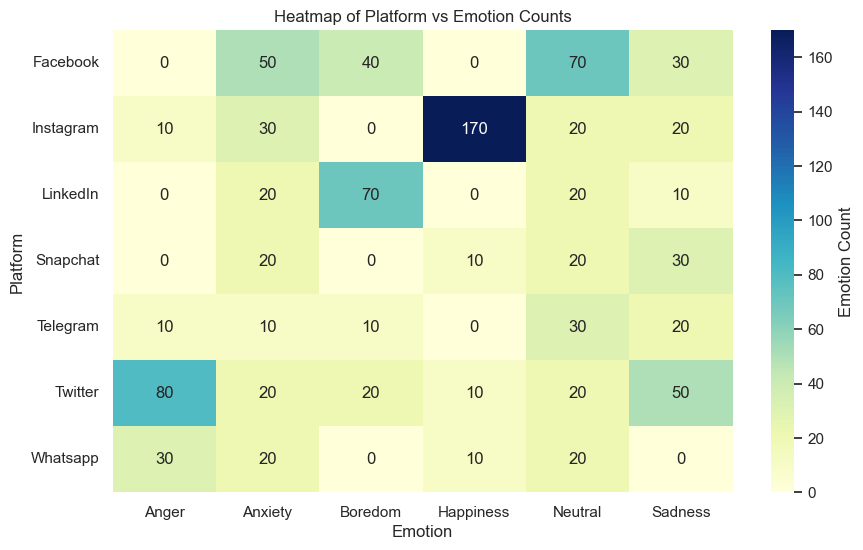

In [11]:
platform_emotion_counts = pd.crosstab(df['Platform'], df['Dominant_Emotion'])

plt.figure(figsize=(10, 6))
sns.heatmap(
    platform_emotion_counts, 
    annot=True, 
    cmap='YlGnBu', 
    fmt='d', 
    cbar_kws={'label': 'Emotion Count'}
)
plt.title('Heatmap of Platform vs Emotion Counts')
plt.xlabel('Emotion')
plt.ylabel('Platform')
plt.show()

Are certain platforms linked to specific emotions (e.g., anxiety, boredom)?

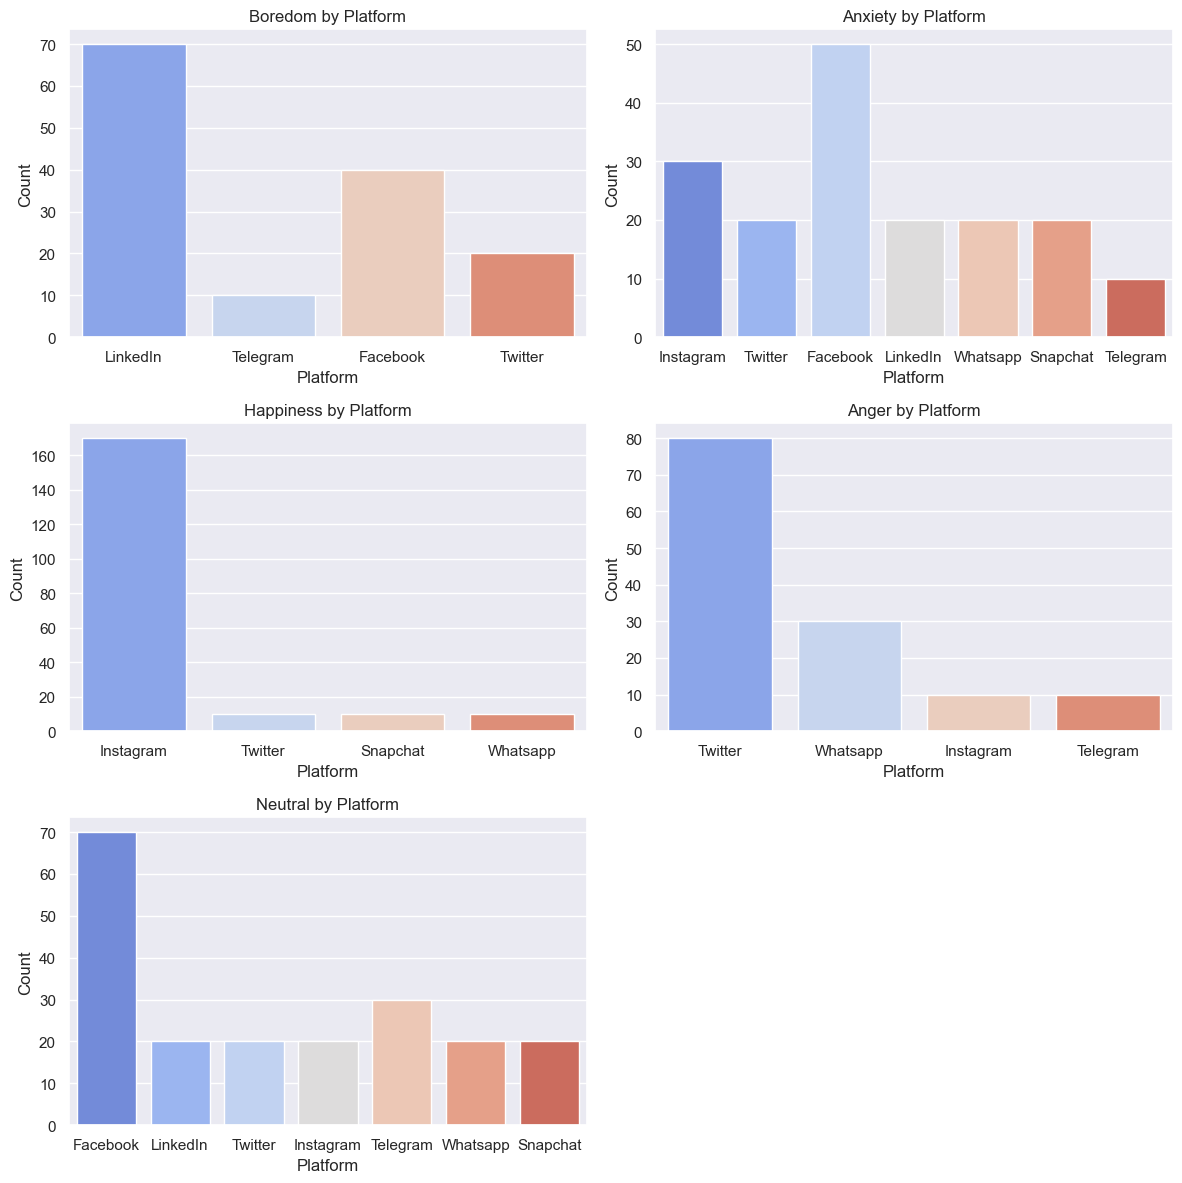

In [12]:
emotions_of_interest = ['Boredom', 'Anxiety', 'Happiness', 'Anger', 'Neutral']  
data_filtered = df[df['Dominant_Emotion'].isin(emotions_of_interest)]

num_plots = len(emotions_of_interest)

plt.figure(figsize=(12, 12))  

for i, emotion in enumerate(emotions_of_interest):
    plt.subplot(3, 2, i + 1)  
    sns.countplot(
        x='Platform', 
        data=data_filtered[data_filtered['Dominant_Emotion'] == emotion], 
        palette='coolwarm',
        legend = False, 
        hue='Platform'
    )
    plt.title(f'{emotion} by Platform')
    plt.xlabel('Platform')
    plt.ylabel('Count')


plt.tight_layout() 
plt.show()

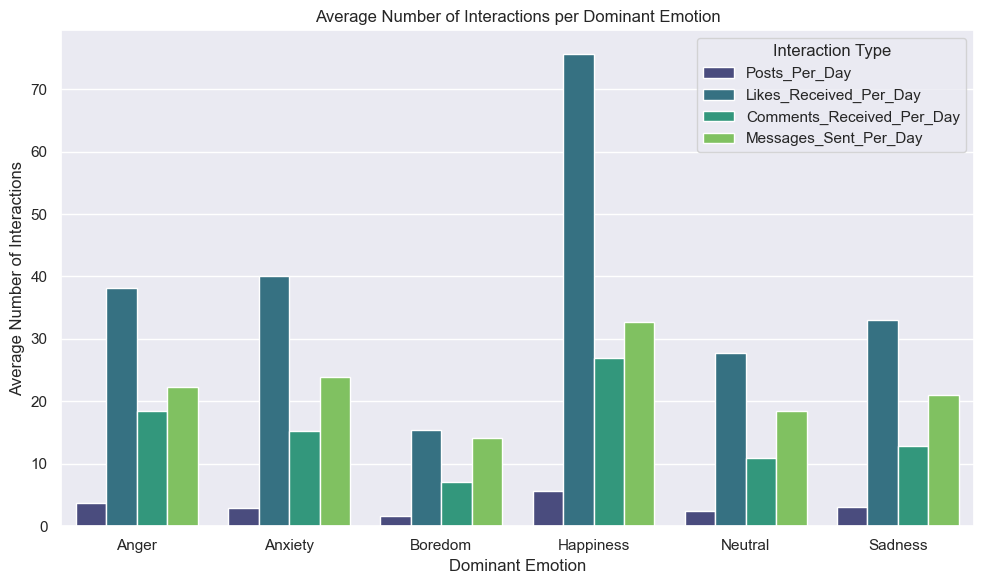

In [13]:
interaction_columns = ['Posts_Per_Day', 'Likes_Received_Per_Day', 'Comments_Received_Per_Day', 'Messages_Sent_Per_Day']
emotion_column = 'Dominant_Emotion'  

interaction_means = df.groupby(emotion_column)[interaction_columns].mean().reset_index()

interaction_means = interaction_means.melt(id_vars=emotion_column, value_vars=interaction_columns,
                                           var_name='Interaction Type', value_name='Average Interactions')

plt.figure(figsize=(10, 6))
sns.barplot(x='Dominant_Emotion', y='Average Interactions', hue='Interaction Type', data=interaction_means, palette='viridis')

plt.title('Average Number of Interactions per Dominant Emotion')
plt.xlabel('Dominant Emotion')
plt.ylabel('Average Number of Interactions')
plt.tight_layout()
plt.show()

# How does daily usage time across different social media platforms relate to dominant emotions?

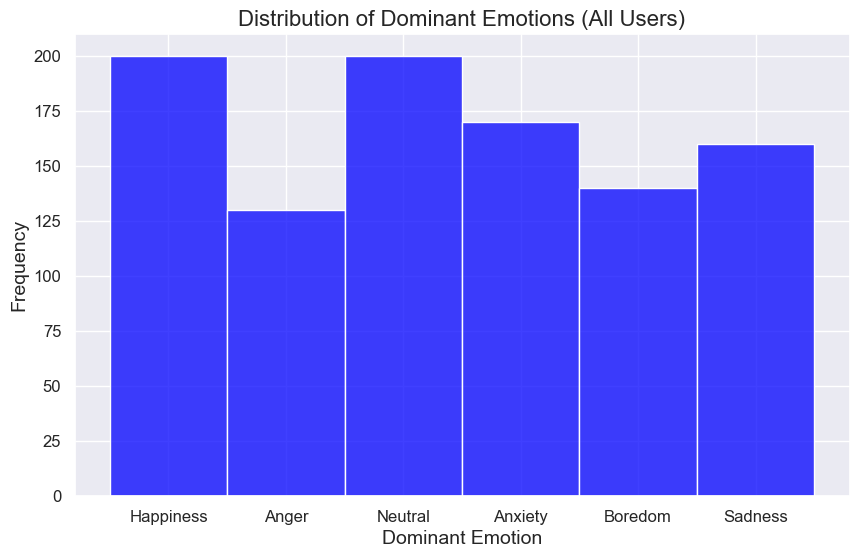

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Dominant_Emotion'], kde=False, color='blue')
plt.title('Distribution of Dominant Emotions (All Users)', fontsize=16)
plt.xlabel('Dominant Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

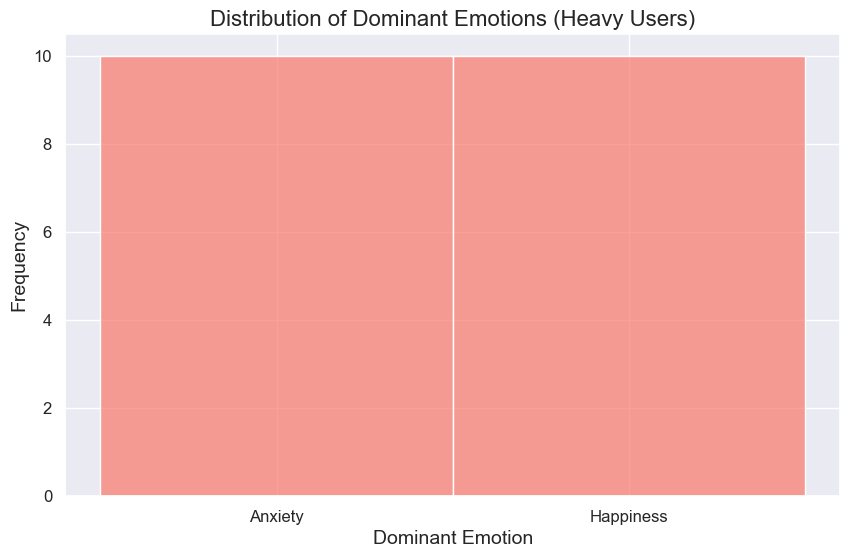

In [15]:
heavy_users = df[df['Daily_Usage_Time (minutes)'] > 180]

plt.figure(figsize=(10, 6))
sns.histplot(heavy_users['Dominant_Emotion'], kde=False, color='salmon')
plt.title('Distribution of Dominant Emotions (Heavy Users)', fontsize=16)
plt.xlabel('Dominant Emotion', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

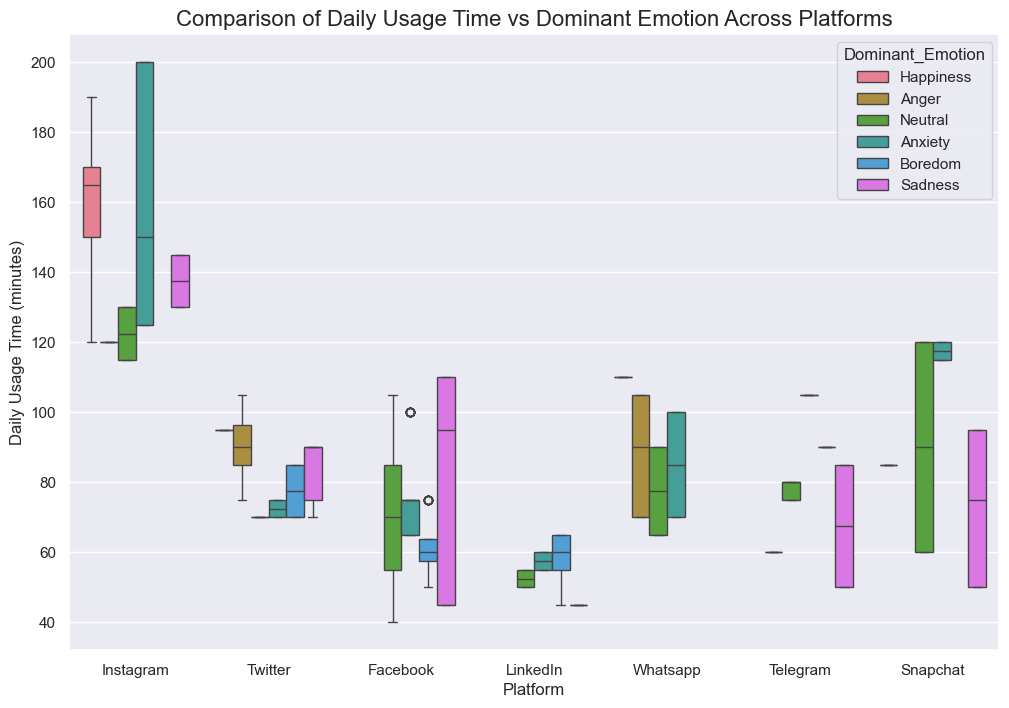

In [16]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Platform', y='Daily_Usage_Time (minutes)', hue='Dominant_Emotion',palette='husl', data=df)

plt.title('Comparison of Daily Usage Time vs Dominant Emotion Across Platforms', fontsize=16)
plt.xlabel('Platform', fontsize=12)
plt.ylabel('Daily Usage Time (minutes)', fontsize=12)

plt.show()

# Is there a correlation between user engagement metrics (likes, comments, messages) and Dominant_Emotion_Happiness or Dominant_Emotion_Anxiety?

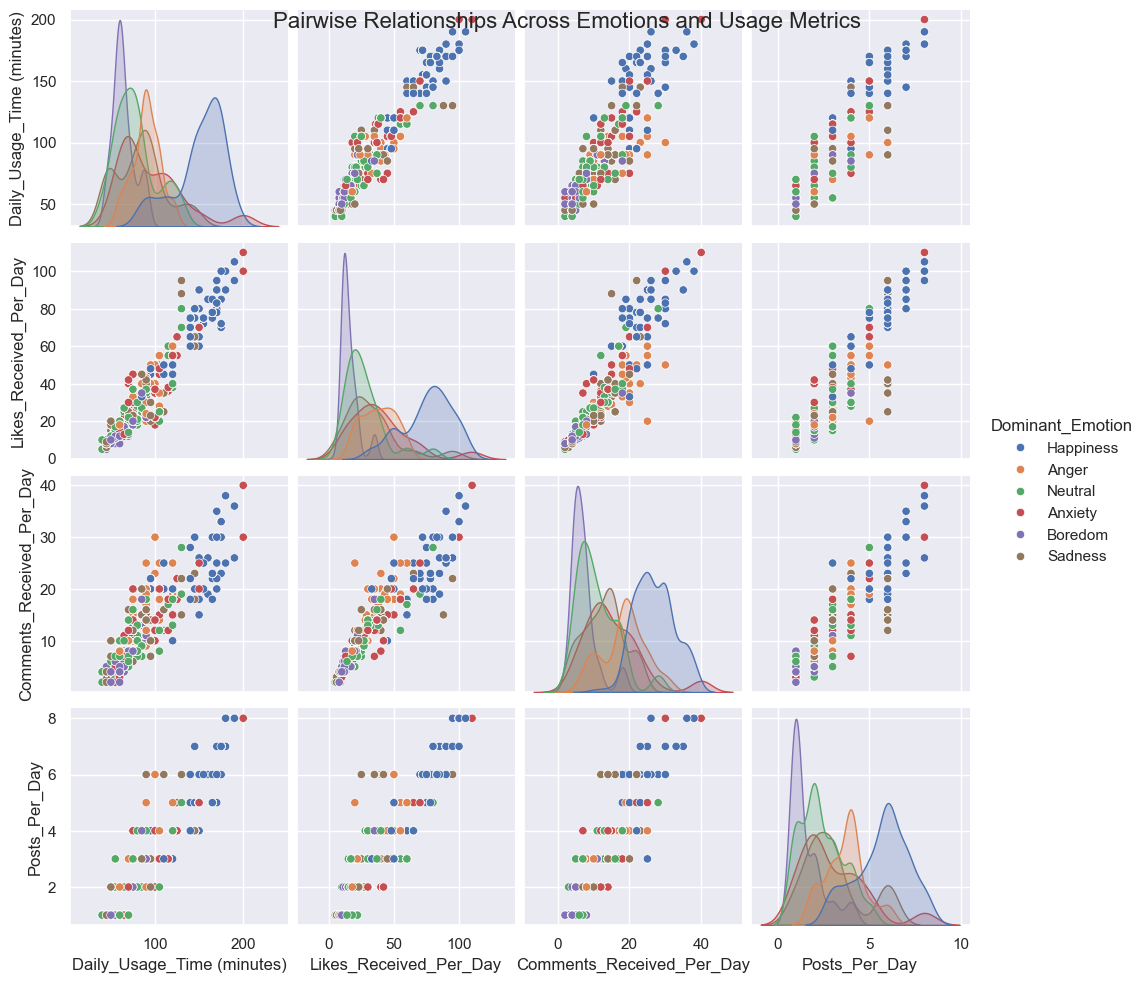

In [17]:
sns.pairplot(df, hue='Dominant_Emotion', vars=['Daily_Usage_Time (minutes)', 'Likes_Received_Per_Day', 'Comments_Received_Per_Day', 'Posts_Per_Day'])
plt.suptitle('Pairwise Relationships Across Emotions and Usage Metrics', fontsize=16)
plt.show()

Correlation Analysis

In [18]:
data_df['Dominant_Emotion_Happiness'] = pd.to_numeric(data_df['Dominant_Emotion_Happiness'], errors='coerce')
data_df['Dominant_Emotion_Anxiety'] = pd.to_numeric(data_df['Dominant_Emotion_Anxiety'], errors='coerce')

correlation_matrix = data_df[['Likes_Received_Per_Day', 'Comments_Received_Per_Day', 'Messages_Sent_Per_Day',
                               'Dominant_Emotion_Happiness', 'Dominant_Emotion_Anxiety']].corr()

print(correlation_matrix)

                            Likes_Received_Per_Day  Comments_Received_Per_Day  \
Likes_Received_Per_Day                    1.000000                   0.931058   
Comments_Received_Per_Day                 0.931058                   1.000000   
Messages_Sent_Per_Day                     0.910030                   0.882778   
Dominant_Emotion_Happiness                0.675156                   0.640088   
Dominant_Emotion_Anxiety                  0.003280                  -0.016486   

                            Messages_Sent_Per_Day  Dominant_Emotion_Happiness  \
Likes_Received_Per_Day                   0.910030                    0.675156   
Comments_Received_Per_Day                0.882778                    0.640088   
Messages_Sent_Per_Day                    1.000000                    0.592258   
Dominant_Emotion_Happiness               0.592258                    1.000000   
Dominant_Emotion_Anxiety                 0.071893                   -0.226713   

                          

* Dominant_Emotion_Happiness is positively correlated with engagement metrics, especially Likes_Received_Per_Day (0.68), Comments_Received_Per_Day (0.64), and Messages_Sent_Per_Day (0.59). This suggests that higher engagement on the platform is associated with higher happiness levels. The more likes, comments, and messages users receive/send, the happier they are likely to feel.

* Dominant_Emotion_Anxiety, however, shows a very weak relationship with the engagement metrics: It has a very low correlation with Likes_Received_Per_Day (0.003) and Comments_Received_Per_Day (-0.02), suggesting no significant relationship.
It has a small positive correlation with Messages_Sent_Per_Day (0.07), though still very weak.

* The Dominant_Emotion_Happiness and Dominant_Emotion_Anxiety variables themselves have a weak negative correlation (-0.23). This suggests that as happiness increases, anxiety tends to decrease slightly, but the relationship is not strong.


In [19]:
correlation_matrix = data_df[['Total_Interactions', 'Dominant_Emotion_Happiness', 'Dominant_Emotion_Anxiety']].corr()
print(correlation_matrix)

                            Total_Interactions  Dominant_Emotion_Happiness  \
Total_Interactions                    1.000000                    0.655799   
Dominant_Emotion_Happiness            0.655799                    1.000000   
Dominant_Emotion_Anxiety             -0.004807                   -0.226713   

                            Dominant_Emotion_Anxiety  
Total_Interactions                         -0.004807  
Dominant_Emotion_Happiness                 -0.226713  
Dominant_Emotion_Anxiety                    1.000000  


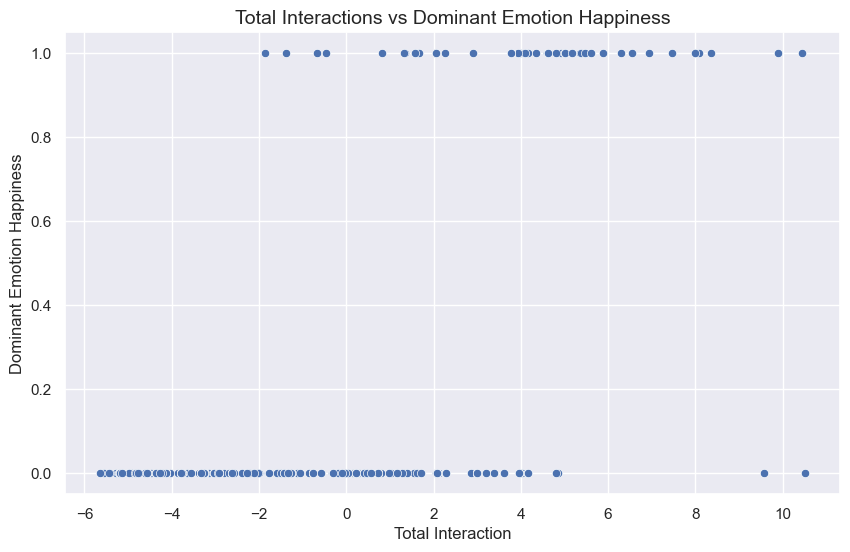

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Interactions', y='Dominant_Emotion_Happiness', data=data_df)
plt.title('Total Interactions vs Dominant Emotion Happiness', fontsize=14)
plt.xlabel('Total Interaction', fontsize=12)
plt.ylabel('Dominant Emotion Happiness', fontsize=12)
plt.show()

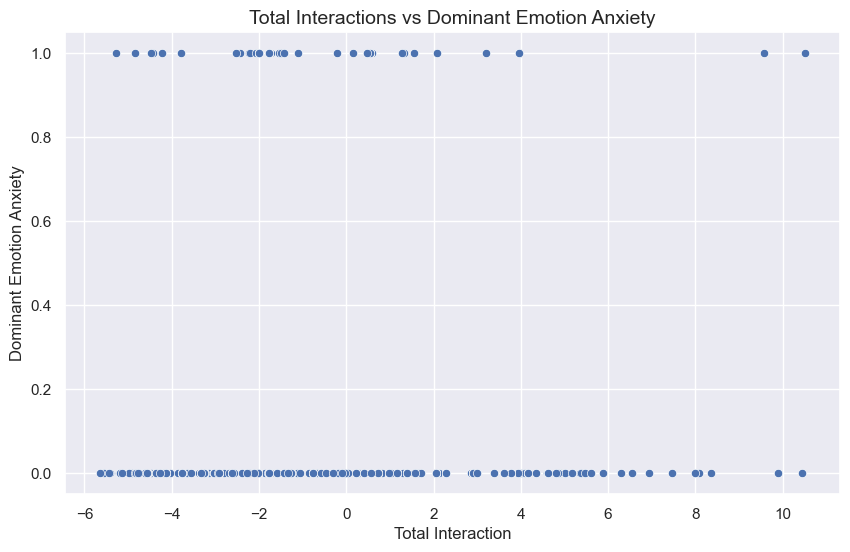

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Total_Interactions', y='Dominant_Emotion_Anxiety', data=data_df)
plt.title('Total Interactions vs Dominant Emotion Anxiety', fontsize=14)
plt.xlabel('Total Interaction', fontsize=12)
plt.ylabel('Dominant Emotion Anxiety', fontsize=12)
plt.show()

Regression Analysis

In [22]:
X = data_df[['Likes_Received_Per_Day', 'Comments_Received_Per_Day', 'Messages_Sent_Per_Day']]
y_happiness = data_df['Dominant_Emotion_Happiness']

regressor = LinearRegression()
regressor.fit(X, y_happiness)

print(f'Intercept (Happiness): {regressor.intercept_}')
print(f'Coefficients(Happiness): {regressor.coef_}')

y_happiness_pred = regressor.predict(X)

# Calculate R² and RMSE for Happiness
r_squared_happiness = regressor.score(X, y_happiness)
rmse_happiness = np.sqrt(mean_squared_error(y_happiness, y_happiness_pred))
print(f'\nR² for Happiness: {r_squared_happiness}')
print(f'RMSE for Happiness: {rmse_happiness}')

y_anxiety = data_df['Dominant_Emotion_Anxiety']

regressor.fit(X, y_anxiety)

print(f'\nIntercept (Anxiety): {regressor.intercept_}')
print(f'Coefficients (Anxiety): {regressor.coef_}')

y_anxiety_pred = regressor.predict(X)

# Calculate R² and RMSE for Anxiety
r_squared_anxiety = regressor.score(X, y_anxiety)
rmse_anxiety = np.sqrt(mean_squared_error(y_anxiety, y_anxiety_pred))
print(f'\nR² for Anxiety: {r_squared_anxiety}')
print(f'RMSE for Anxiety: {rmse_anxiety}')

#Faster way: 
import statsmodels.api as sm

X = data_df['Total_Interactions']
y_happiness = data_df['Dominant_Emotion_Happiness']
y_anxiety = data_df['Dominant_Emotion_Anxiety']

X = sm.add_constant(X)

model_happiness = sm.OLS(y_happiness, X).fit()

model_anxiety = sm.OLS(y_anxiety, X).fit()

print(model_happiness.summary())
print(model_anxiety.summary())

Intercept (Happiness): 0.2007992007992008
Coefficients(Happiness): [ 0.27947493  0.05111999 -0.0622007 ]

R² for Happiness: 0.4607397795652739
RMSE for Happiness: 0.29417660877731827

Intercept (Anxiety): 0.16983016983016985
Coefficients (Anxiety): [-0.06088193 -0.10079585  0.17137951]

R² for Anxiety: 0.03670752122920462
RMSE for Anxiety: 0.36852756684992516
                                OLS Regression Results                                
Dep. Variable:     Dominant_Emotion_Happiness   R-squared:                       0.430
Model:                                    OLS   Adj. R-squared:                  0.430
Method:                         Least Squares   F-statistic:                     753.9
Date:                        Tue, 27 Jan 2026   Prob (F-statistic):          4.13e-124
Time:                                19:38:26   Log-Likelihood:                -223.24
No. Observations:                        1001   AIC:                             450.5
Df Residuals:                

#Likes, Comments & Messages

* Likes and Comments: Both have a negative impact on anxiety, meaning that increased engagement in terms of likes and comments could help reduce anxiety.

* Messages Sent: This variable has a positive impact on anxiety, which suggests that sending more messages might be associated with higher anxiety levels.

#Total Interactions:
1. Dominant_Emotion_Happiness:

R-squared: 0.430
43% of the variance in Dominant_Emotion_Happiness can be explained by Total_Interactions. There is still 57% of the variance unexplained by this model, suggesting that other factors might also influence happiness.

Coefficient for Total_Interactions: 0.0681
This indicates that for each additional unit of Total_Interactions, Dominant_Emotion_Happiness increases by 0.0681. In other words, higher engagement is positively associated with higher happiness levels.

P-value for Total_Interactions: < 0.001
The p-value is very small, which means that the relationship between Total_Interactions and Dominant_Emotion_Happiness is statistically significant.

Conclusion: There is a positive and significant relationship between user engagement (Total_Interactions) and Happiness. The more interactions a user has, the more likely they are to report feeling happy.

2. Dominant_Emotion_Anxiety:

R-squared: 0.000
This suggests that Total_Interactions has almost no explanatory power for Dominant_Emotion_Anxiety. Essentially, the total interactions don't explain any variance in anxiety based on this model.

Coefficient for Total_Interactions: -0.0005
This coefficient suggests a slight negative relationship between Total_Interactions and Dominant_Emotion_Anxiety, but the effect is extremely small.

P-value for Total_Interactions: 0.879
The p-value is very high, indicating that this relationship is not statistically significant.

R² for Anxiety: 0.037
This indicates that only 3.7% of the variance in Dominant_Emotion_Anxiety is explained by the features included in the model. This is a very low R² value, which suggests that the current set of features (Likes, Comments, Messages Sent) is not very effective in predicting anxiety.

Conclusion: There is no significant relationship between Total_Interactions and Dominant_Emotion_Anxiety in this model. Even though the coefficient is negative, the lack of significance (p-value = 0.879) suggests no meaningful association between engagement and anxiety.

* Key Takeaways:

Positive Impact on Happiness: Total_Interactions (likes, comments, messages) have a statistically significant positive relationship with Dominant_Emotion_Happiness. This suggests that higher engagement correlates with higher happiness levels.

No Impact on Anxiety: There is no significant relationship between Total_Interactions and Dominant_Emotion_Anxiety, meaning engagement metrics do not explain changes in anxiety levels based on this analysis.



1. Messages Sent Per Day and Posts Per Day seem to have the most significant impact on anxiety. Specifically, more messages sent per day are associated with higher anxiety, while more posts per day are associated with lower anxiety.
2. Daily usage time has a negative association with anxiety, though this relationship is counterintuitive and might require further investigation to understand fully.

# How does age and/or gender affect emotional responses to social media usage?

In [23]:
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   User_ID                     1001 non-null   object  
 1   Age                         1001 non-null   int64   
 2   Daily_Usage_Time (minutes)  1001 non-null   float64 
 3   Posts_Per_Day               1001 non-null   float64 
 4   Likes_Received_Per_Day      1001 non-null   float64 
 5   Comments_Received_Per_Day   1001 non-null   float64 
 6   Messages_Sent_Per_Day       1001 non-null   float64 
 7   Gender_Male                 1001 non-null   bool    
 8   Gender_Non-binary           1001 non-null   bool    
 9   Platform_Instagram          1001 non-null   bool    
 10  Platform_LinkedIn           1001 non-null   bool    
 11  Platform_Snapchat           1001 non-null   bool    
 12  Platform_Telegram           1001 non-null   bool    
 13  Platform_Twitter  

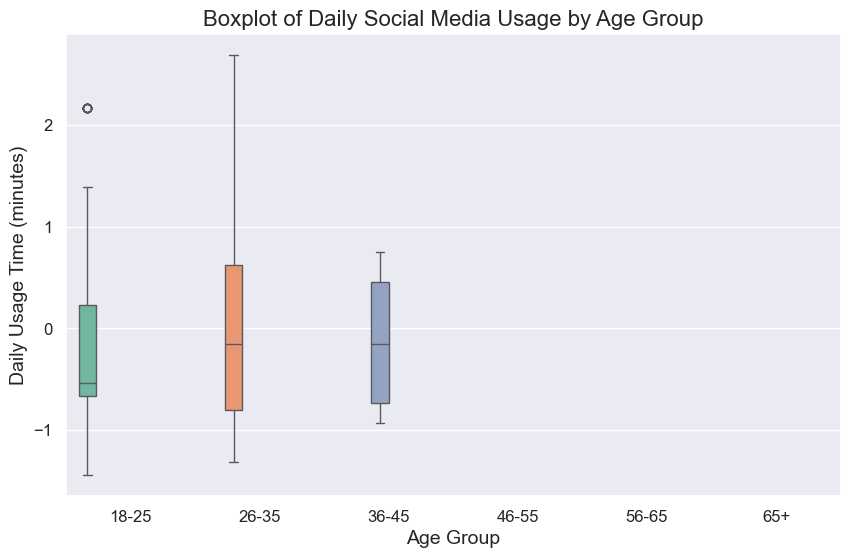

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_Group', y='Daily_Usage_Time (minutes)', hue='Age_Group', legend=False, data=data_df, palette='Set2')
plt.title('Boxplot of Daily Social Media Usage by Age Group', fontsize=16)
plt.xlabel('Age Group', fontsize=14)
plt.ylabel('Daily Usage Time (minutes)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

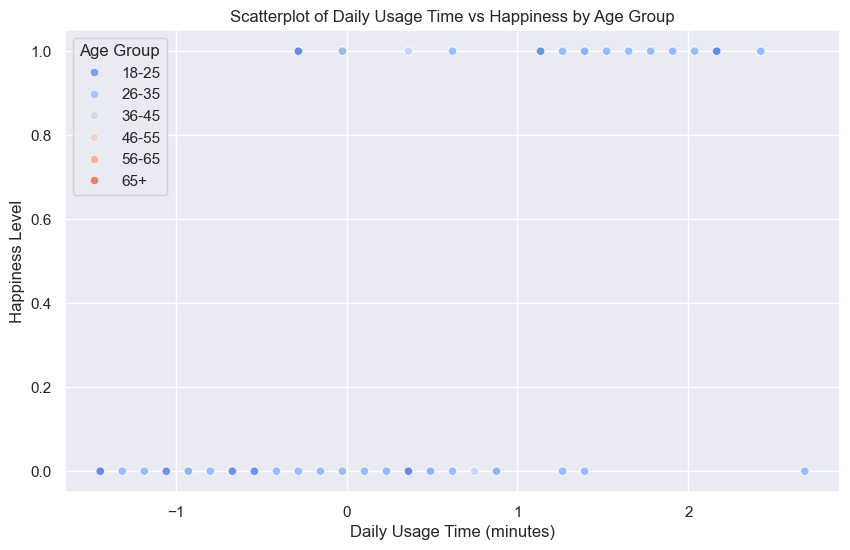

In [25]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_df,
    x='Daily_Usage_Time (minutes)',
    y='Dominant_Emotion_Happiness',
    hue='Age_Group',
    palette='coolwarm',
    alpha=0.8
)

plt.title('Scatterplot of Daily Usage Time vs Happiness by Age Group')
plt.xlabel('Daily Usage Time (minutes)')
plt.ylabel('Happiness Level')
plt.legend(title='Age Group')
plt.show()

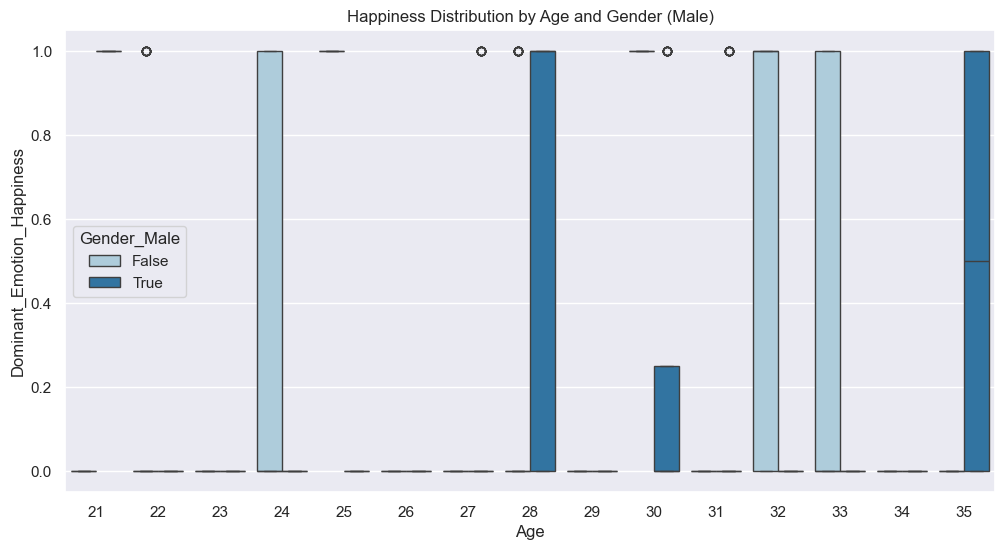

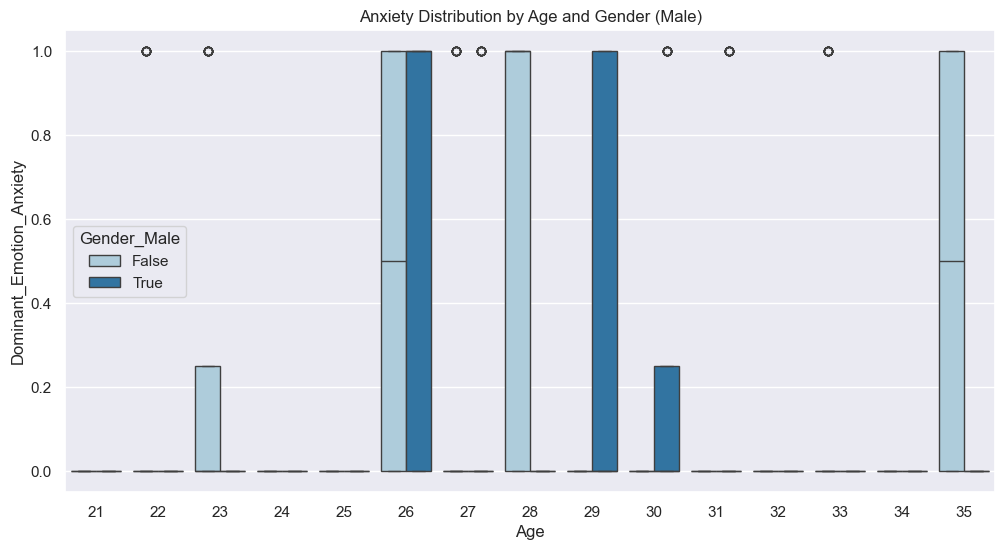

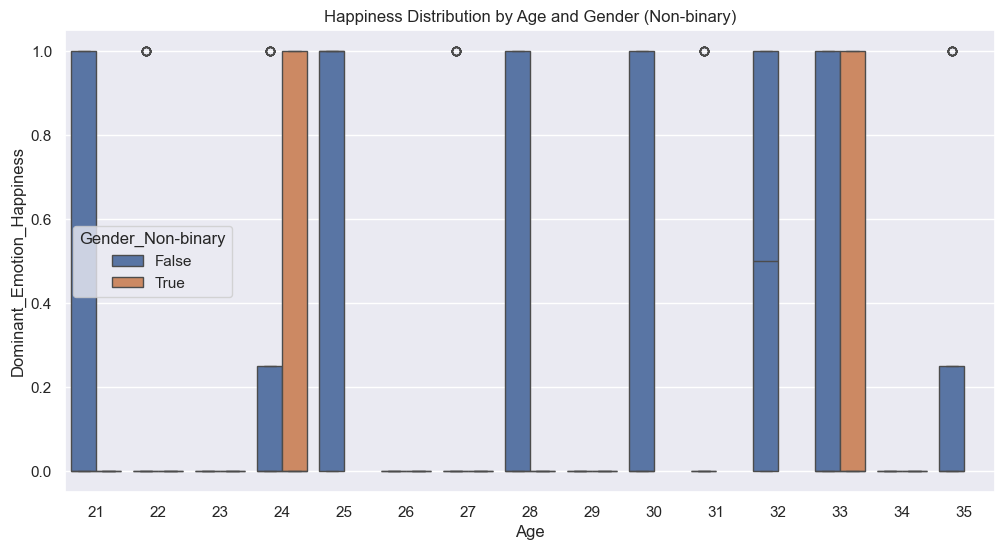

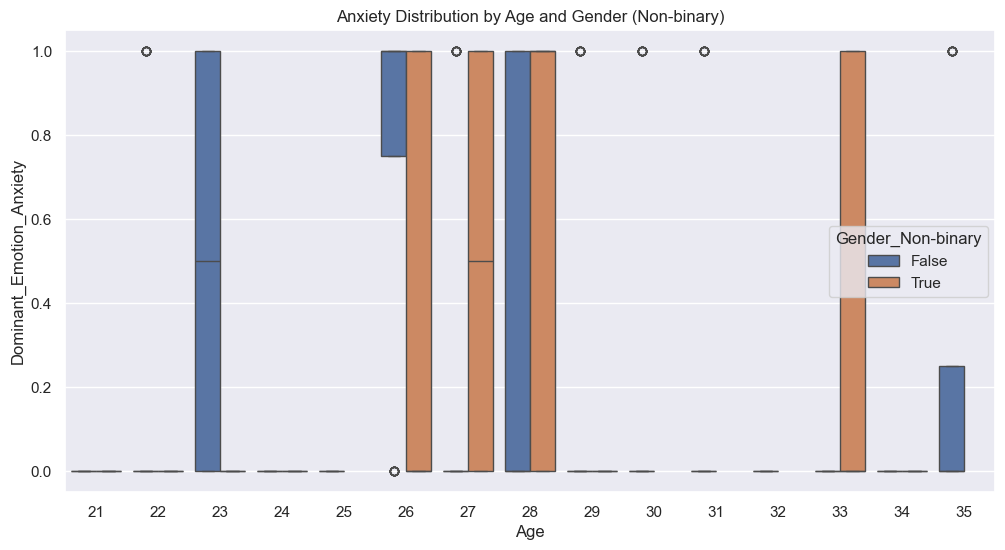

In [26]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Dominant_Emotion_Happiness',  palette='Paired', hue='Gender_Male', data=data_df)
plt.title('Happiness Distribution by Age and Gender (Male)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Dominant_Emotion_Anxiety',  palette='Paired', hue='Gender_Male', data=data_df)
plt.title('Anxiety Distribution by Age and Gender (Male)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Dominant_Emotion_Happiness', hue='Gender_Non-binary', data=data_df)
plt.title('Happiness Distribution by Age and Gender (Non-binary)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Dominant_Emotion_Anxiety', hue='Gender_Non-binary', data=data_df)
plt.title('Anxiety Distribution by Age and Gender (Non-binary)')
plt.show()

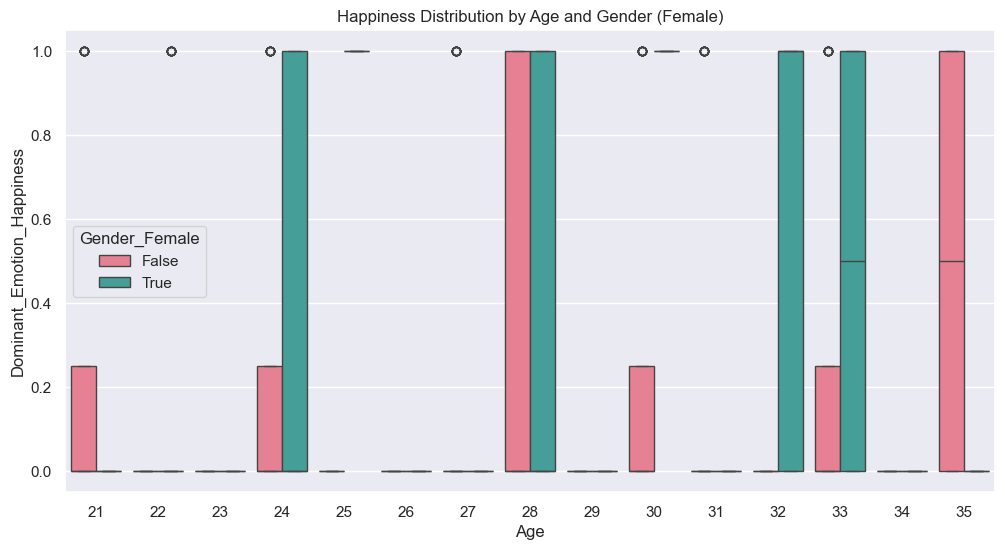

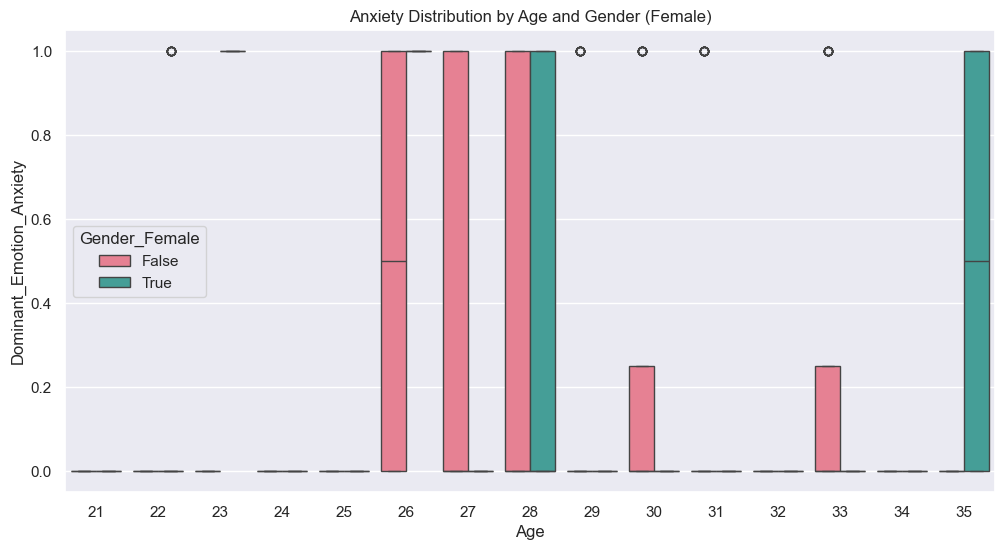

In [27]:
data_df['Gender_Female'] = ~(data_df['Gender_Male'] | data_df['Gender_Non-binary'])

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Dominant_Emotion_Happiness', palette="husl", hue='Gender_Female', data=data_df)
plt.title('Happiness Distribution by Age and Gender (Female)')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='Age', y='Dominant_Emotion_Anxiety', palette="husl", hue='Gender_Female', data=data_df)
plt.title('Anxiety Distribution by Age and Gender (Female)')
plt.show()

Clustering

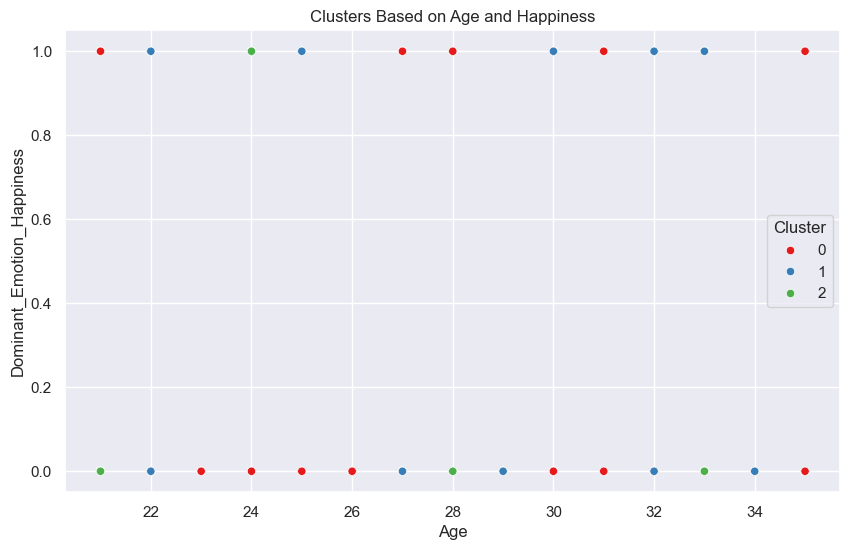

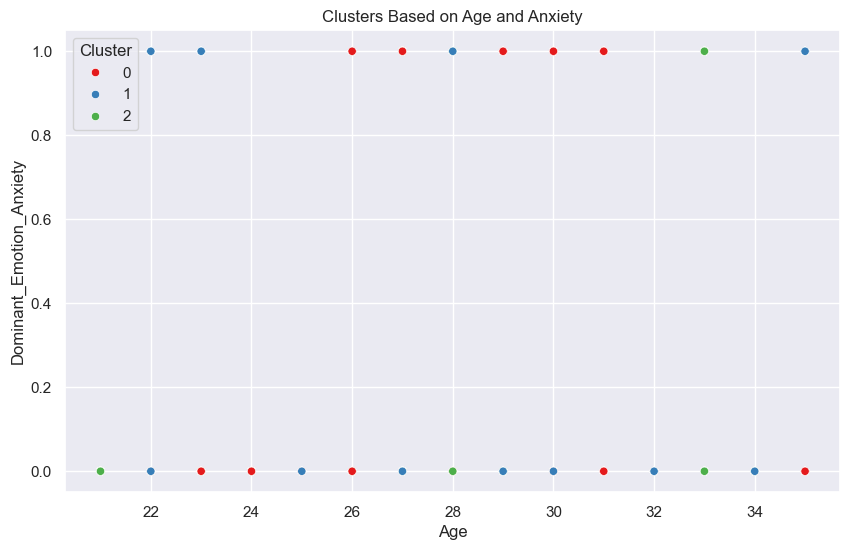

In [28]:
from sklearn.cluster import KMeans

X = data_df[['Age', 'Gender_Male', 'Gender_Female', 'Gender_Non-binary', 'Dominant_Emotion_Happiness', 'Dominant_Emotion_Anxiety']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=3, random_state=42)
data_df['Cluster'] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_df, x='Age', y='Dominant_Emotion_Happiness', hue='Cluster', palette='Set1')
plt.title('Clusters Based on Age and Happiness')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_df, x='Age', y='Dominant_Emotion_Anxiety', hue='Cluster', palette='Set1')
plt.title('Clusters Based on Age and Anxiety')
plt.show()

Classification

Accuracy: 0.8637873754152824
Classification Report Happiness:
               precision    recall  f1-score   support

           0       0.87      0.97      0.92       236
           1       0.82      0.48      0.60        65

    accuracy                           0.86       301
   macro avg       0.84      0.72      0.76       301
weighted avg       0.86      0.86      0.85       301



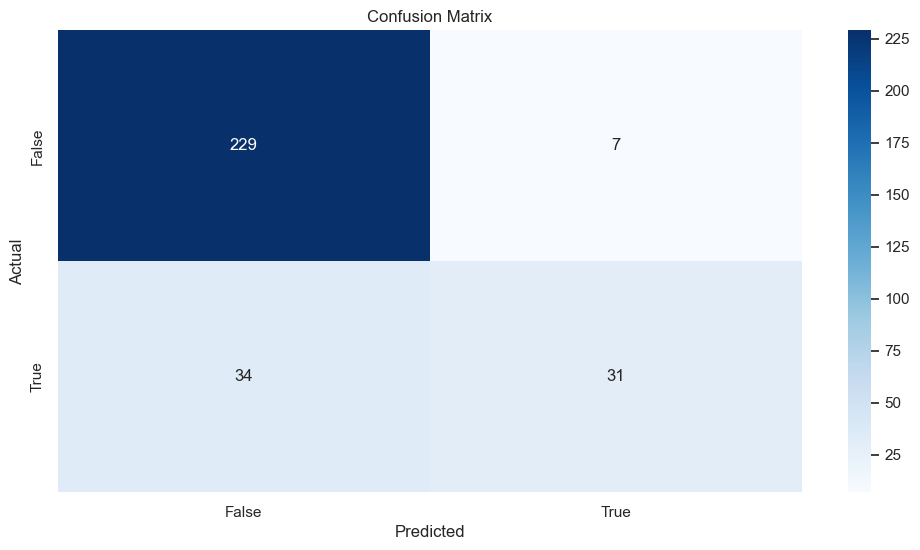

In [29]:
from sklearn.ensemble import RandomForestClassifier

X = data_df[['Age', 'Gender_Male', 'Gender_Non-binary']]  
y = data_df['Dominant_Emotion_Happiness']  

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report Happiness:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Accuracy: 0.8504983388704319
Classification Report Anxiety:
               precision    recall  f1-score   support

           0       0.91      0.90      0.91       250
           1       0.56      0.59      0.57        51

    accuracy                           0.85       301
   macro avg       0.74      0.75      0.74       301
weighted avg       0.85      0.85      0.85       301



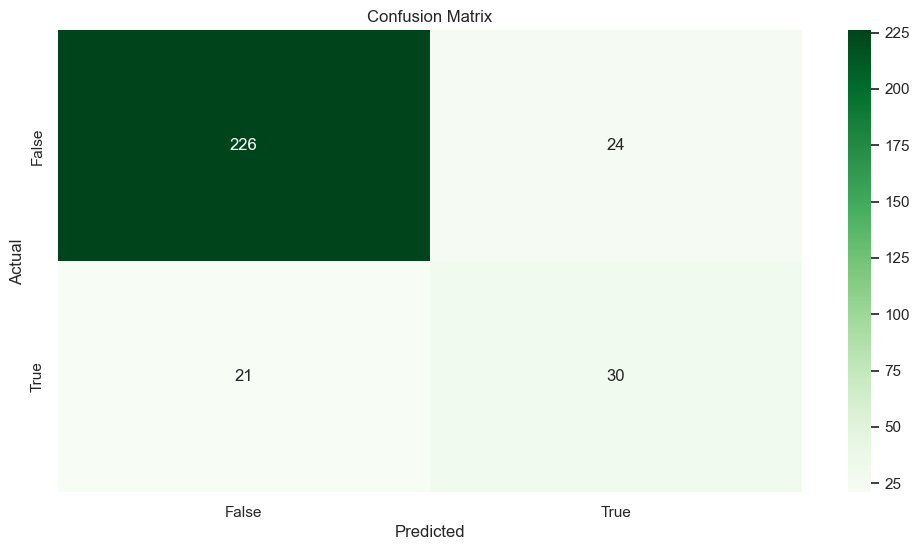

In [30]:
y = data_df['Dominant_Emotion_Anxiety']

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report Anxiety:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()